Load in the PWM file Dan used

In [1]:
motifs_file = "/mnt/lab_data/kundaje/users/dskim89/ggr/integrative/v1.0.0a/annotations/HOCOMOCOv11_core_pwms_HUMAN_mono.renamed.nonredundant.txt"
motif_order = [x[1:].rstrip() for x in open(motifs_file)
               if x.startswith(">")]




In [2]:
motif_name_to_index = dict([(x[1], x[0]) for x in enumerate(motif_order)])

View the enrichments of different PWMs across time (computed by Dan)

In [3]:
pwm_scores = "/mnt/lab_data/kundaje/users/dskim89/ggr/nn/inference.2019-03-12/motifs.sig/motifs.adjust.diff.rna_filt.dmim/summary/ggr.pwms_present_summary.txt"

In [4]:
import numpy as np
motif_names = []
matrix = []
for rowidx, row in enumerate(open(pwm_scores)):
    if (rowidx==0):
        colnames = row.rstrip().split("\t")[1:]
    else:
        splitrow = row.strip().split("\t")
        motif_names.append(splitrow[0])
        matrix.append([float(x) for x in splitrow[1:]])
matrix = np.array(matrix)

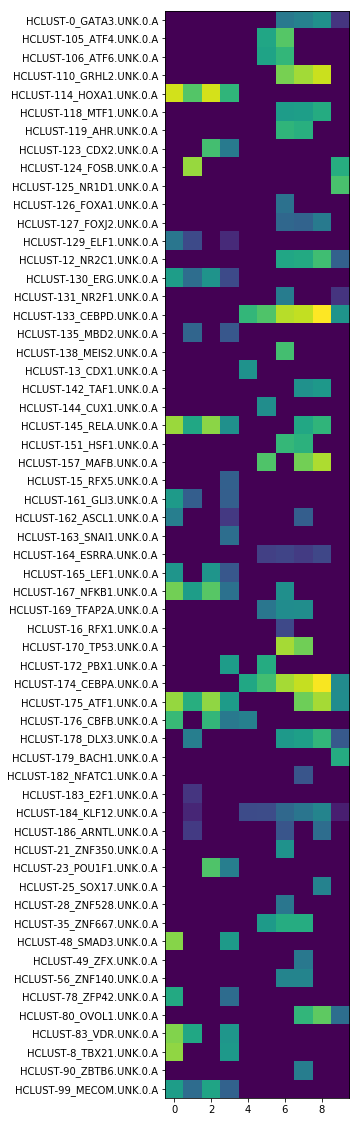

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(20,20))
plt.imshow(matrix)
plt.yticks(np.arange(len(motif_names)))
plt.gca().set_yticklabels(motif_names)
plt.show()

Pick a motif and a task to look at

In [6]:
motif_to_look_at = "HCLUST-0_GATA3.UNK.0.A"
task_to_look_at = 9
motif_idx = motif_name_to_index[motif_to_look_at]

Load in Dan's thresholded scores for that motif and task, visualize

In [7]:
import h5py
ggr_scanmotifs_scores = "/mnt/lab_data/kundaje/users/dskim89/ggr/nn/inference.2019-02-05/motifs.input_x_grad.late/ggr.scanmotifs.h5"
f = h5py.File(ggr_scanmotifs_scores)
scores_for_task_and_motif = f["sequence-weighted.active.pwm-scores.thresh"][:,task_to_look_at,:,motif_idx]

In [11]:
list(f.keys())

['ATAC_LABELS',
 'ATAC_SIGNALS',
 'ATAC_SIGNALS.NORM',
 'CTCF_LABELS',
 'CTCF_SIGNALS',
 'CTCF_SIGNALS.NORM',
 'DYNAMIC_MARK_LABELS',
 'DYNAMIC_STATE_LABELS',
 'H3K27ac_LABELS',
 'H3K27ac_SIGNALS',
 'H3K27ac_SIGNALS.NORM',
 'H3K27me3_LABELS',
 'H3K27me3_SIGNALS',
 'H3K27me3_SIGNALS.NORM',
 'H3K4me1_LABELS',
 'H3K4me1_SIGNALS',
 'H3K4me1_SIGNALS.NORM',
 'KLF4_LABELS',
 'POL2_LABELS',
 'STABLE_MARK_LABELS',
 'STABLE_STATE_LABELS',
 'TP63_LABELS',
 'TRAJ_LABELS',
 'ZNF750_LABELS',
 'example_metadata',
 'gradients',
 'labels',
 'logits',
 'logits.ci',
 'logits.ci.thresh',
 'logits.multimodel',
 'logits.multimodel.norm',
 'logits.norm',
 'positive_importance_bp_sum',
 'probs',
 'pwm-scores.null.idx',
 'sequence',
 'sequence-weighted',
 'sequence-weighted.active',
 'sequence-weighted.active.ci',
 'sequence-weighted.active.ci.thresh',
 'sequence-weighted.active.pwm-scores.thresh',
 'sequence-weighted.active.pwm-scores.thresh.max.idx',
 'sequence-weighted.active.pwm-scores.thresh.max.val',
 's

In [9]:
#sort the sequences in order of the max score for the motif
maxscore_seq_indices =(
    sorted(enumerate(np.max(scores_for_task_and_motif, axis=-1)),
           key=lambda x: -x[1]))                                

index 9699


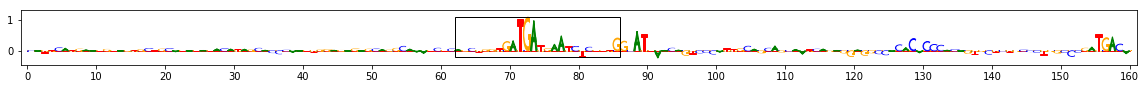

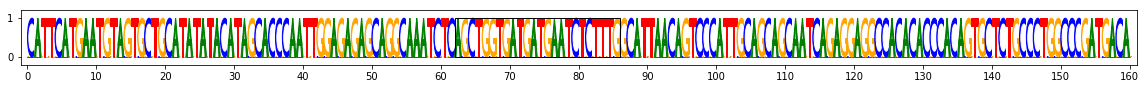

index 17682


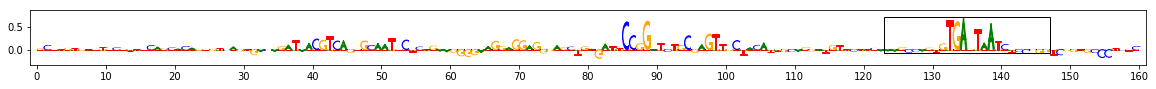

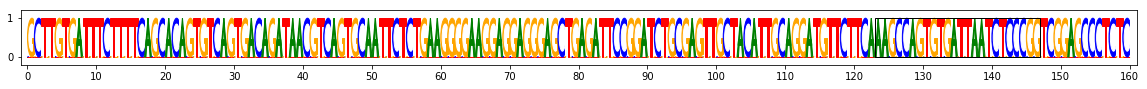

index 9682


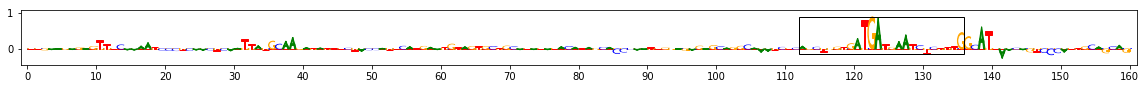

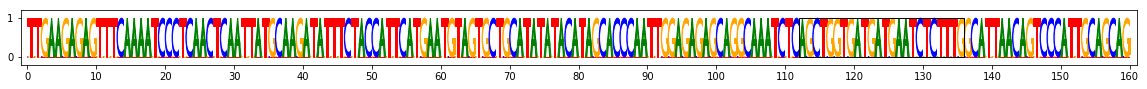

index 16884


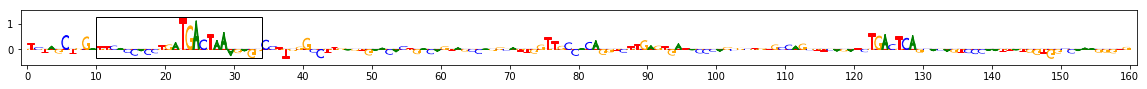

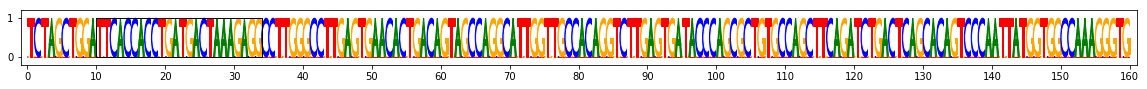

index 10732


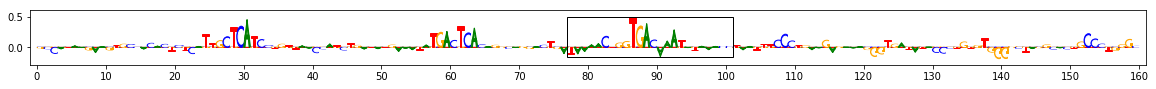

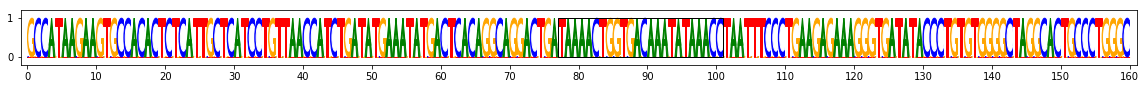

index 2256


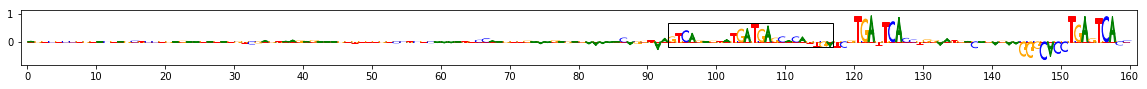

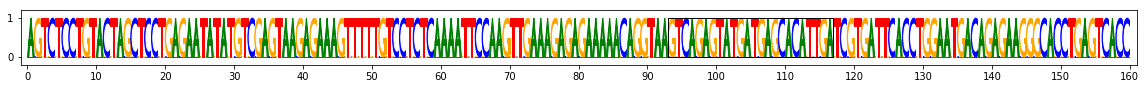

index 7890


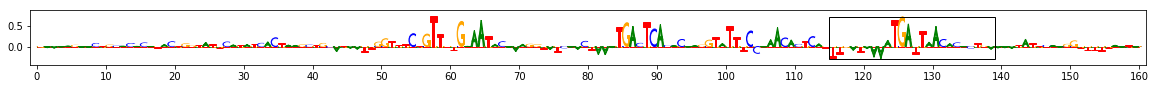

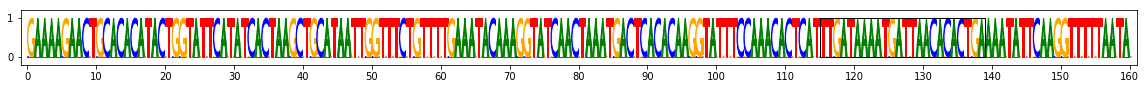

index 17000


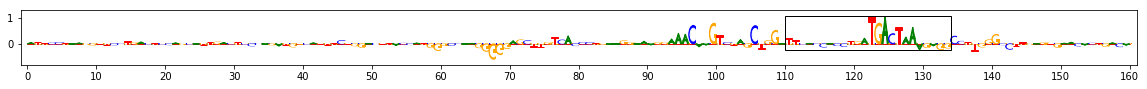

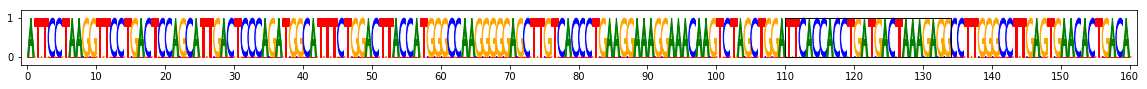

index 98


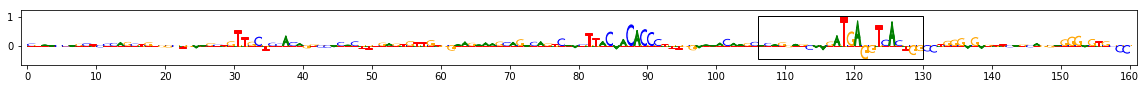

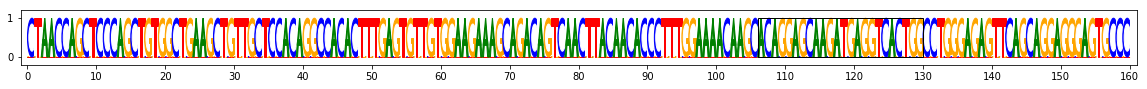

index 4895


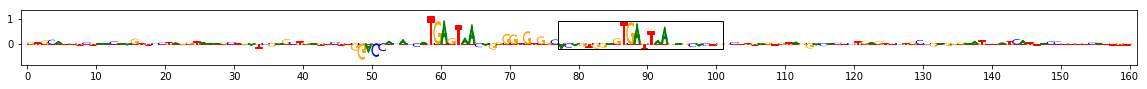

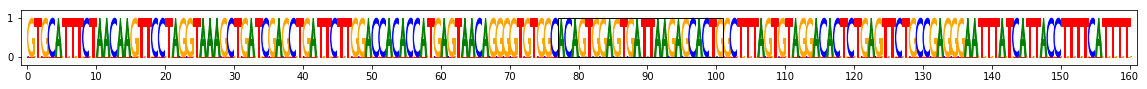

In [10]:
#visualize the first 10
from modisco.visualization import viz_sequence
for idx, max_score in maxscore_seq_indices[:10]:
    print("index",idx)
    max_idx = np.argmax(
        f["sequence-weighted.active.pwm-scores.thresh"][idx,task_to_look_at,:,motif_idx])
    viz_sequence.plot_weights(f["sequence-weighted"][
        idx,task_to_look_at,420:580], highlight={"black": [(max_idx,max_idx+24)]},
        subticks_frequency=10, figsize=(20,1))
    viz_sequence.plot_weights(f["sequence.active"][
        idx], highlight={"black": [(max_idx,max_idx+24)]},
        subticks_frequency=10, figsize=(20,1))

Instead implement a scanning strategy that likely has fewer false positives

In [13]:
GATA_pwm = np.array(
[[1.12689900806, -3.32473679114, -3.12621061112, -0.181446971283],
 [-2.96064388965, -3.5726905309, 1.36298929777, -4.40005804045],
 [1.36500928154, -3.5726905309, -3.32473679114, -3.90314184382],
 [-0.52914731733, -2.96064388965, -1.77012107524, 1.15964310055],
 [1.29609620967, -2.58374285258, -1.72476933978, -2.39366476533],
 [1.23595164016, -3.90314184382, -0.957996931092, -1.86750427161],
 [0.274651146968, -0.108390914634, 0.475263271519, -1.72476933978]])

In [26]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def scan_deeplift_scores_with_pwm(imp_scores, pwm):
    strided_arr = rolling_window(imp_scores.transpose((0,2,1)),
                                 window=len(pwm)).transpose((0,2,3,1))
    #report both the sum and the cosine similarity
    #this finds the sum
    sum_scores = np.sum(strided_arr, axis=(2,3))
    #this finds the cosine similarity with a masked version of the pwm
    # where only the positions that are nonzero in the deeplift scores are
    # considered
    dot_product_pwm = np.sum(strided_arr*pwm[None,None,:,:], axis=(2,3))
    norm_deeplift_scores = np.sqrt(np.sum(np.square(strided_arr), axis=(2,3)))
    norm_masked_pwm = np.sqrt(np.sum(np.square((np.abs(strided_arr)>0)*pwm[None,None,:,:]), axis=(2,3)))
    cosine_sim = dot_product_pwm/(norm_deeplift_scores*norm_masked_pwm)
    return sum_scores, cosine_sim
  
imp_scores = np.array(f["sequence-weighted"][:,task_to_look_at,420:580])
motif_sum_scores, motif_cosine_sim =\
    scan_deeplift_scores_with_pwm(imp_scores=imp_scores, pwm=GATA_pwm)
    

In [30]:
#mask by cases where total importance is > 1,
# then sort by cosine sim
#First get the indices of those examples where the total importance
# is greater than 1
sumscores_mask_idx1, sumscores_mask_idx2 = np.nonzero(motif_sum_scores > 1)
#Then sort in descending order by cosine similarity
sorted_matches = sorted(
    [(motif_cosine_sim[idx1, idx2],
     motif_sum_scores[idx1, idx2], idx1, idx2)
     for (idx1, idx2) in
     zip(sumscores_mask_idx1, sumscores_mask_idx2)],
     key=lambda x: -x[0])

0.9532192833805766 1.0356584 9209 111


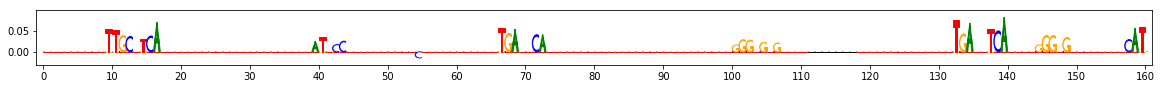

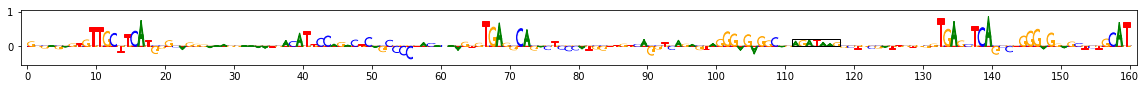

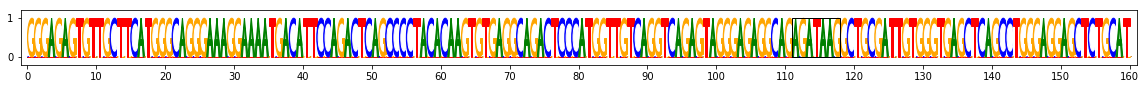

0.9443608825703956 1.7891053 11792 81


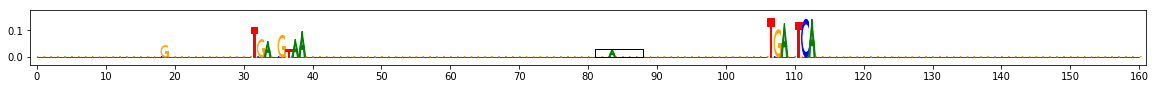

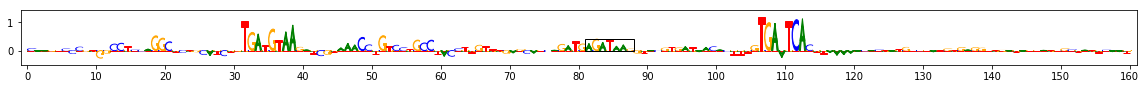

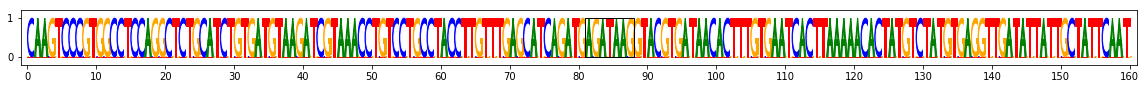

0.9400037275979283 1.1209041 6891 51


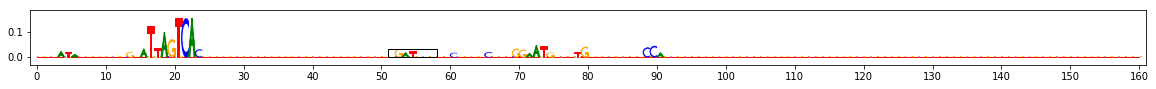

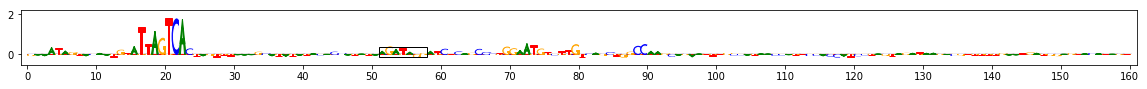

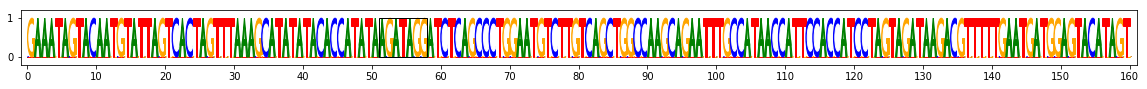

0.9377424877477839 1.2725705 11472 35


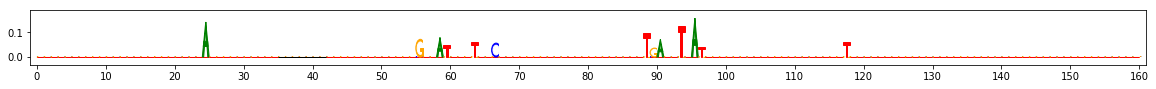

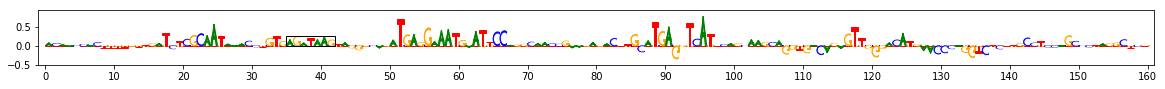

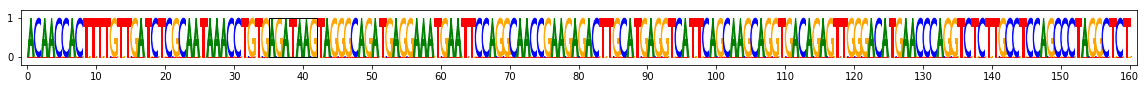

0.9364571792800964 1.490466 6629 14


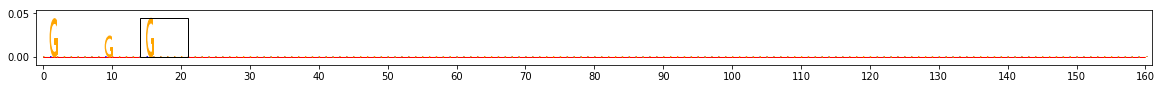

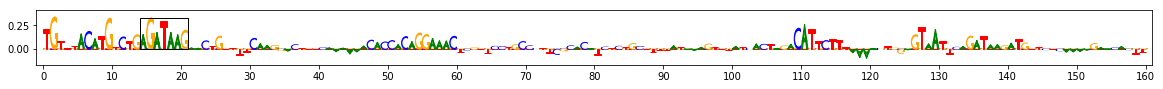

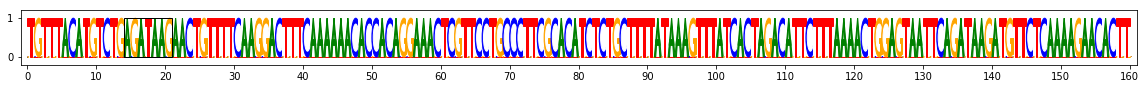

0.9351979437032049 1.318582 11778 131


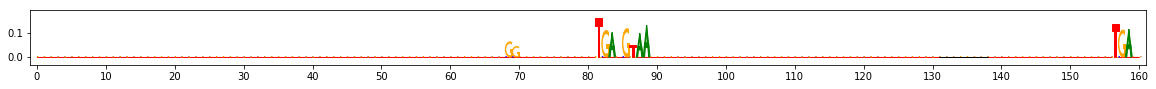

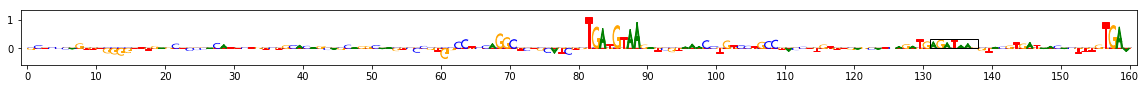

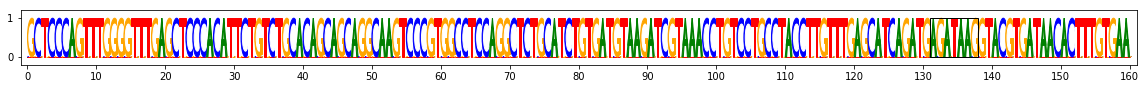

0.9271841408368197 1.3381705 10872 67


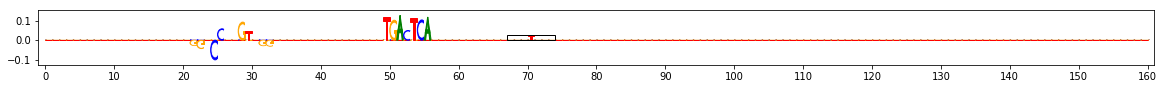

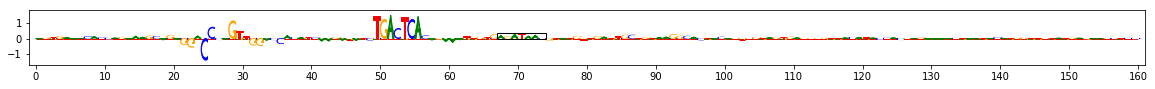

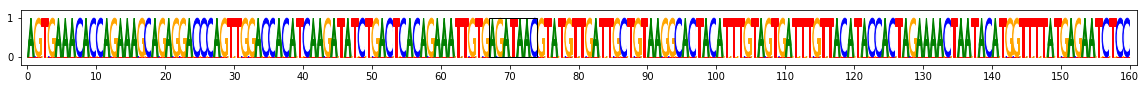

0.9254223707795286 1.2233264 13961 147


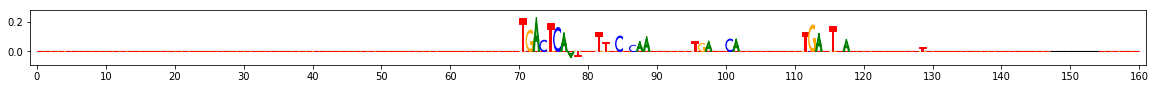

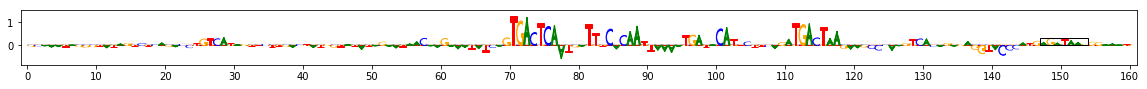

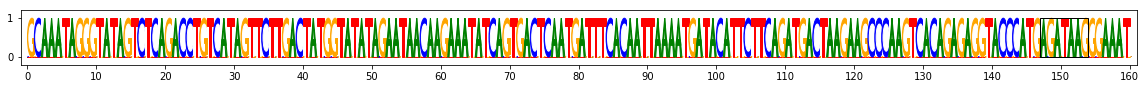

0.9253546210637184 1.7090585 17567 52


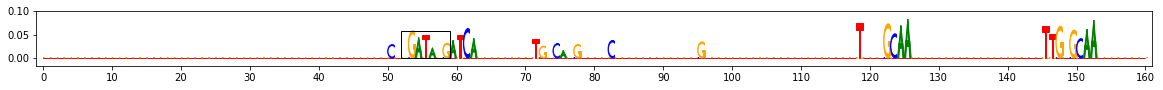

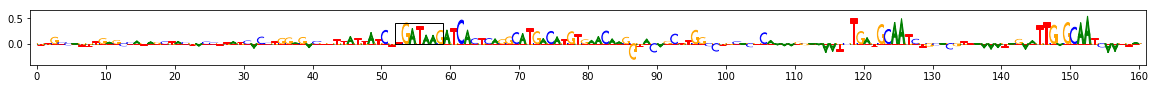

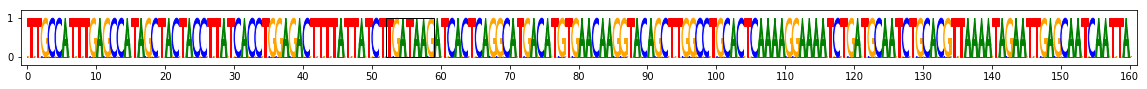

0.9247589195333116 1.4209002 13937 47


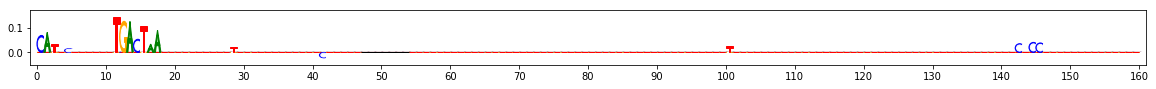

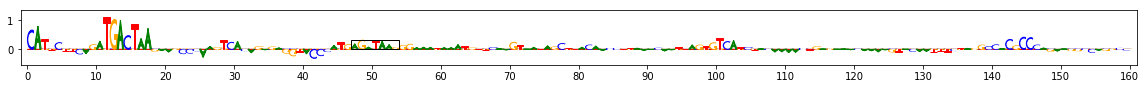

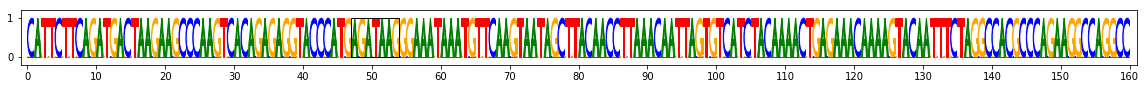

In [32]:
#display the top 10 matches that have total importance > 1
for cosine_sim, sum_score, idx1, idx2 in sorted_matches[:10]:
    print(cosine_sim, sum_score, idx1, idx2)
    viz_sequence.plot_weights(f["sequence-weighted.active"][idx1,task_to_look_at],
        highlight={"black": [(idx2,idx2+len(GATA_pwm))]},
        subticks_frequency=10, figsize=(20,1))
    viz_sequence.plot_weights(f["sequence-weighted"][
        idx1,task_to_look_at,420:580],
        highlight={"black": [(idx2,idx2+len(GATA_pwm))]},
        subticks_frequency=10, figsize=(20,1))
    viz_sequence.plot_weights(f["sequence.active"][
        idx1], highlight={"black": [(idx2,idx2+len(GATA_pwm))]},
        subticks_frequency=10, figsize=(20,1))